In [1]:
import ycbvideo
from ycbvideo.frame_access import FrameAccessor
import plotly.express as px
import plotly.graph_objects as go
import torch
from pixtrack.utils.pytorch3d_render_utils import (
    render_image, 
    create_colmap_camera,
    create_colmap_image_from_pytorch3d_RT,
    create_look_at_camera_poses
)
from pytorch3d.io import load_objs_as_meshes
from pathlib import Path
import numpy as np

import os
os.environ['OBJ_AABB'] = "[[0., 0., 0.], [1., 1., 1.]]"
import cv2
import matplotlib.pyplot as plt
from pixtrack.visualization.run_vis_on_poses import get_nerf_image
from pixtrack.utils.pose_utils import get_world_in_camera_from_pixpose, get_camera_in_world_from_colmap_image, rotate_image, get_camera_in_world_from_pixpose
from pixtrack.utils.ingp_utils import load_nerf2sfm, initialize_ingp, sfm_to_nerf_pose, nerf_to_sfm_pose
from pixloc.pixlib.geometry import Pose, Camera as PixCamera
from hloc.utils.read_write_model import Camera as ColCamera
import pycolmap

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
mesh_path = Path('/data/ycb/models/003_cracker_box/textured.obj')
mesh = load_objs_as_meshes([mesh_path], device=device)

In [3]:
# frame_accessor = FrameAccessor('/data/ycb/')
# frame = frame_accessor.get_frame((7, 2000))

In [4]:
# intrinsics = frame.meta['intrinsic_matrix']
# print(intrinsics)
# pose = frame.meta['poses'][:, :, 0]
# pose[0, :] *= -1.
# pose[1, :] *= -1.
# print(pose)
# fx = intrinsics[0, 0]
# fy = intrinsics[1, 1]
# cx = intrinsics[0, 2]
# cy = intrinsics[1, 2]
# k1 = 0.
# H, W, _ = frame.color.shape
# R = torch.tensor(pose[:3, :3]).T
# T = torch.tensor(pose[:3, 3])

In [5]:
# intrinsics = frame.meta['intrinsic_matrix']
# pose = frame.meta['poses'][:, :, 0]

# print(pose)
# fx = intrinsics[0, 0]
# fy = intrinsics[0, 0]
# cx = intrinsics[0, 2]
# cy = intrinsics[1, 2]
# k1 = 0.
# H, W, _ = frame.color.shape
# flip = np.eye(3)
# flip[0, 0] = -1.0
# flip[1, 1] = -1.0
# R_colmap = pose[:3, :3].T @ flip
# R = torch.tensor(R_colmap)
# T = torch.tensor(pose[:3, 3])

In [6]:
# image = render_image(mesh, fx, fy, cx, cy, W, H, R.unsqueeze(0), T.unsqueeze(0))
# fig = px.imshow(image[:, :, :3] * 0.6 + frame.color * 0.4 / 255.)
# fig.show()

In [7]:
# image = render_image(mesh, fx, fy, cx, cy, W, H, R.unsqueeze(0), T.unsqueeze(0))
# fig = px.imshow(image[:, :, :3] * 0.6 + frame.color * 0.4 / 255.)
# fig.show()

In [8]:
nerf_path = '/data/pixtrack/objects/003_cracker_box/pixtrack/instant-ngp/snapshots/weights.msgpack'
nerf2sfm_path = '/data/pixtrack/objects/003_cracker_box/pixtrack/pixsfm/dataset/nerf2sfm.pkl'
nerf2sfm = load_nerf2sfm(nerf2sfm_path)
testbed = initialize_ingp(nerf_path)

20:22:55 INFO     Loading network config from: /data/pixtrack/objects/003_cracker_box/pixtrack/instant-ngp/snapshots/weights.msgpack
20:22:55 INFO     GridEncoding:  Nmin=16 b=1.51572 F=2 T=2^19 L=16
20:22:55 INFO     Density model: 3--[HashGrid]-->32--[FullyFusedMLP(neurons=64,layers=3)]-->1
20:22:55 INFO     Color model:   3--[Composite]-->16+16--[FullyFusedMLP(neurons=64,layers=4)]-->3
20:22:55 INFO       total_encoding_params=13074912 total_network_params=10240


In [13]:
frame_accessor = FrameAccessor('/data/ycb/')
frame = frame_accessor.get_frame((35, 1))
intrinsics = frame.meta['intrinsic_matrix']
pose = frame.meta['poses'][:, :, 0]
R = pose[:, :3]
T = pose[:, 3]

fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
k1 = 0.
H, W, _ = frame.color.shape

In [21]:
import math
def get_nerf_image(testbed, nerf_pose, camera):
    print('TESTING!!!')
    spp = 8
    width, height = camera.size
    width = int(width)
    height = int(height)
    fl_x = float(camera.f[0])
    fl_y = float(camera.f[1])
    angle_x = math.atan(width / (fl_x * 2)) * 2
    angle_y = math.atan(height / (fl_y * 2)) * 2

    testbed.fov = angle_x * 180 / np.pi
    #testbed.fovx = angle_x * 180 / np.pi
    #testbed.fovy = angle_y * 180 / np.pi
    #testbed.fov_xy = np.array((angle_y * 180 / np.pi, angle_x * 180 / np.pi))


    testbed.set_nerf_camera_matrix(nerf_pose[:3, :])

    #import pdb; pdb.set_trace()
    ncx = camera.c[0] / float(width)
    ncy = camera.c[1] / float(height)
    testbed.screen_center = np.array([ncx, ncy])

    nerf_img = testbed.render(width, height, spp, True)
    nerf_img = nerf_img[:, :, :3] * 255.
    nerf_img = nerf_img.astype(np.uint8)
    return nerf_img

In [39]:
# colmap_image = create_colmap_image_from_pytorch3d_RT(R, T, 'gt_pose', 1, 1)
# rotation = colmap_image.qvec2rotmat()
# translation = colmap_image.tvec
pixpose = Pose.from_Rt(R, T)
#camera = create_colmap_camera(W, H, fx, cx, cy, k1)
camera = ColCamera(
        id=1,
        model="OPENCV",
        width=W,
        height=H,
        params=np.array([fx, fy, cx, cy]),
    )
pix_camera = PixCamera.from_colmap(camera)
cIw_sfm = get_camera_in_world_from_pixpose(pixpose)
nerf_pose = sfm_to_nerf_pose(nerf2sfm, cIw_sfm)
testbed.screen_center = np.array([0.5, 0.5])
testbed.render_mode = testbed.render_mode.Depth
nerf_img = get_nerf_image(testbed, nerf_pose, pix_camera)

TESTING!!!



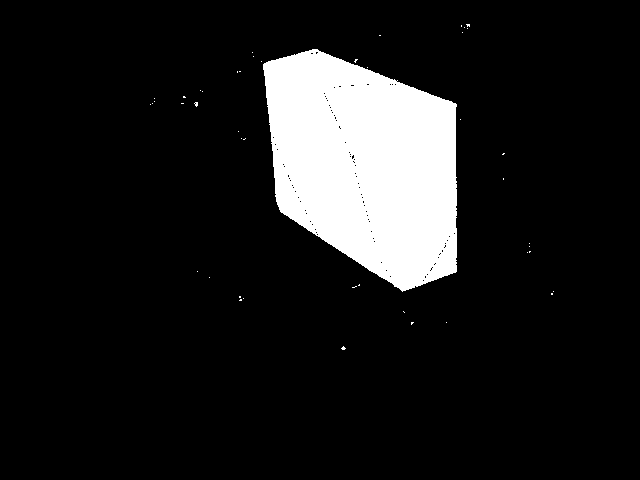

In [41]:
fig = px.imshow(nerf_img != 0)
fig.show()

In [69]:
kernel = np.ones((5, 5), np.uint8)
img_erosion = cv2.erode((nerf_img != 0).astype(np.uint8), kernel, iterations=1)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=5)

In [70]:
img_erosion.max()

1


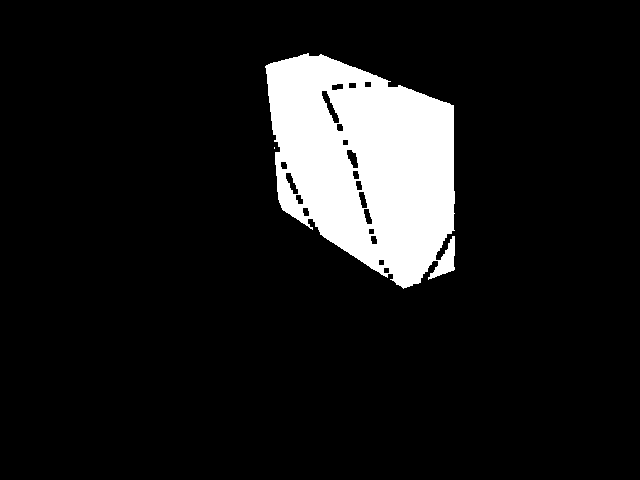

In [71]:
fig = px.imshow(img_erosion * 255)
fig.show()


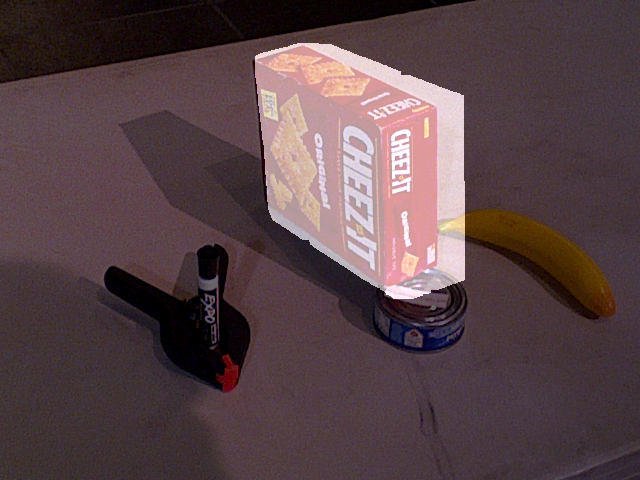

In [72]:
fig = px.imshow(img_dilation * 255 * 0.6 + frame.color * 0.4)
fig.show()


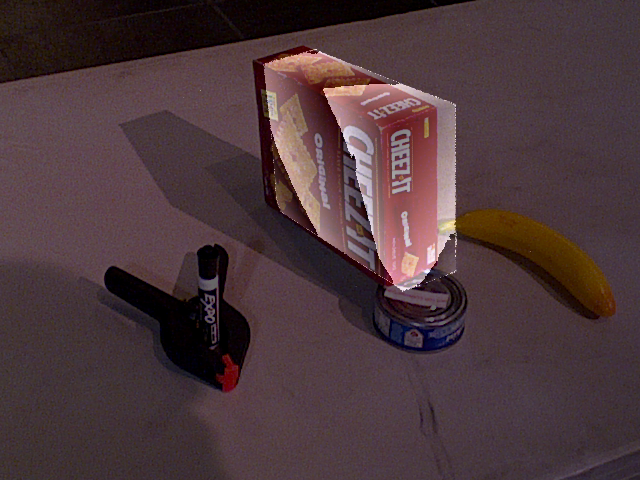

In [73]:
fig = px.imshow(nerf_img * 0.6 + frame.color * 0.4)
fig.show()


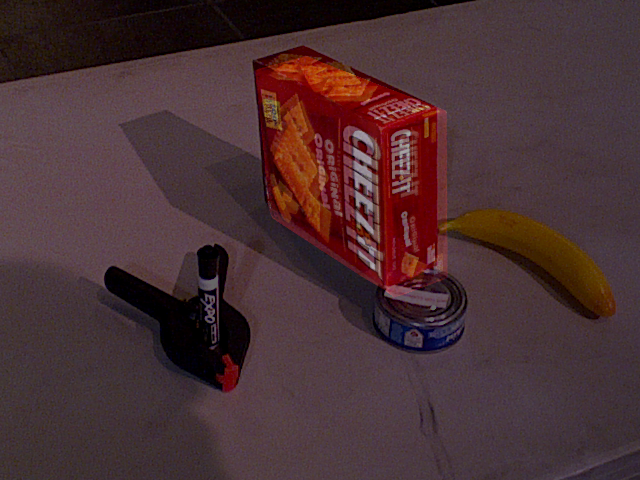

In [15]:
fig = px.imshow(nerf_img * 0.6 + frame.color * 0.4)
fig.show()

In [ ]:
fig = px.imshow(nerf_img * 0.6 + frame.color * 0.4)
fig.show()

In [ ]:
fig = px.imshow(nerf_img * 0.6 + frame.color * 0.4)
fig.show()

In [ ]:
verts = mesh.verts_list()[0].cpu().numpy()

In [ ]:
x, y, z = verts[:, 0], verts[:, 1], verts[:, 2]

In [ ]:
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   alphahull=5,
                   opacity=0.4,
                   color='cyan')])
fig.show()